<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/1-computer-vision-lab/3-using-deconvnet-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional visualization by attaching deconvnet to each conv layer! ##

(https://arxiv.org/pdf/1311.2901.pdf)

<img src="https://github.com/aeau/MAU-AML-labs/blob/develop/figures/deconvolutional-network-zeiler-fergus.png?raw=1" width="800">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import requests
import numpy as np
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
specfic_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip'
#!ls "$root_dir"
root_dir = "/content/data"

!unzip '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip' -d "$root_dir"


Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/MNIST.zip
   creating: /content/data/MNIST/
  inflating: /content/data/MNIST/.DS_Store  
  inflating: /content/data/__MACOSX/MNIST/._.DS_Store  
   creating: /content/data/MNIST/processed/
   creating: /content/data/MNIST/raw/
  inflating: /content/data/MNIST/processed/training.pt  
  inflating: /content/data/MNIST/processed/test.pt  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz  


In [5]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
            
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        # Necessary information for the deconvnet
        self.maxpool_indices = [] # 2, [0: [0,1,2, ... ,n], 1]
        self.feature_maps = [] # size = 4
        self.deconvs = {}
        
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def initialize_deconv(self):
        
        self.deconvs = nn.Sequential(
            nn.MaxUnpool2d(2, stride=2),
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=5),
            nn.MaxUnpool2d(2, stride=2),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5)
        )
        
        self.deconvs[1].weight.data = self.conv2.weight.data 
        self.deconvs[3].weight.data = self.conv1.weight.data
       
    def forward(self, x, verbose=False):
        self.feature_maps = []
        self.maxpool_indices = []
        
        x = self.conv1(x)
        self.feature_maps.append(x)
        
        x = F.relu(x)
        
        x, ind = self.pool1(x)
        self.feature_maps.append(x)
        self.maxpool_indices.append(ind)
        
        x = self.conv2(x)
        self.feature_maps.append(x)
        
        x = F.relu(x)
        
        x, ind = self.pool2(x)
        self.feature_maps.append(x)
        self.maxpool_indices.append(ind)
        
        self.prefc = x
        
        x = x.view(-1, self.n_feature*4*4) #flatten is the same
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def deconv(self, x, layer):     
        start_pos = abs(((layer * 2) - len(self.deconvs)) + 2)
        next_layer = layer
        
        for idx in range(start_pos, len(self.deconvs), 1):
            if isinstance(self.deconvs[idx], nn.MaxUnpool2d):
                x = self.deconvs[idx](x, self.maxpool_indices[next_layer])
                x = F.relu(x)
                next_layer = next_layer - 1
            else:
                x = self.deconvs[idx](x)
                
        return x


In [6]:
model_cnn = CNN(28, 6, 10)
print(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [8]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [9]:
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308597
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.100530
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.647668
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.255563
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.297346
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.442102
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.229769
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.317161
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.321447
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.374914

Test set: Average loss: 0.1628, Accuracy: 9503/10000 (95%)



In [10]:
model_cnn.to("cpu")
model_cnn.initialize_deconv() # Now that the network is trained we can initialize those weights and layers!

tensor([3])


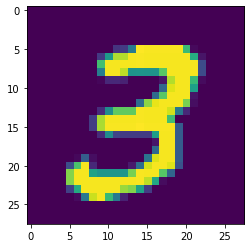

In [11]:
model_cnn.eval()
image, _ = train_loader.dataset[7]
plt.imshow(image.squeeze().numpy())
inp = image.unsqueeze(dim=0)
result = model_cnn(inp)
print(result.argmax(1))

In [12]:
def visualize_layer(layer, max_act):
    pos = layer * 2 + 1 # this is due to how I created the arrays in the network.

    num_feat = model_cnn.feature_maps[pos].shape[1]

    #Get all the specific feature maps!
    new_feat_map = model_cnn.feature_maps[pos].clone()
#     print(new_feat_map.shape)

    # Choose max activation
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())
    
#     print(act_lst)
    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst) #Get index of max activation
    top_k = (-act_lst).argsort()[:3]
    mark = (-act_lst).argsort()[:max_act][max_act - 1]

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)

    # make zeros for other feature maps - we are only interested in the top! (or the max_act we choose)
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != num_feat - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
            
#     print(max_activation)
#     print(choose_map)

    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )
    
#     print(choose_map)

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
#     print(new_feat_map)

    deconv_output = model_cnn.deconv(new_feat_map, layer)
    return deconv_output

# print(new_feat_map.shape)

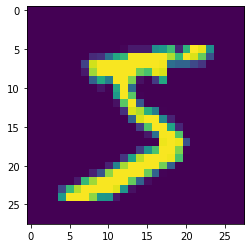

tensor([5])


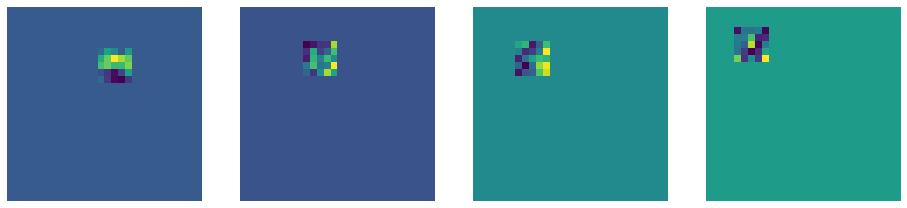

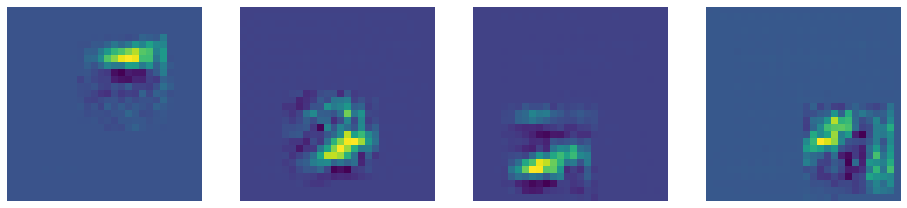

In [13]:
# We pass one image through the model
model_cnn.eval()
image, _ = train_loader.dataset[0]
plt.imshow(image.squeeze().numpy())
plt.show()
inp = image.unsqueeze(dim=0)
result = model_cnn(inp)
print(result.argmax(1))

# Now that we did the feedforward pass, we can go backwards through the deconvnet
for layer in range(0, 2):
    imgs = []
    for top_k in range(1, 5):
        deconv_output = visualize_layer(layer, top_k)
        imgs.append(deconv_output.squeeze().detach().numpy())
    
    ## PLOT
    plt.figure(figsize=(16, 6))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        image, _ = train_loader.dataset.__getitem__(i)
        plt.imshow(imgs[i])
        plt.axis('off');
    
    plt.show()

## try blending the images to see them stack together ##

In the original paper, they used the top 9.

## Here you could/should try to apply the same idea (deconvnet) to a pre-trained model, loaded as we have seen before ##

You will need to load the model layer by layer and then use the weights similar to how we did in this notebook